In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import scipy 
import torch 
from models import MatrixTreeMarkovICL, RandomPolynomialICL, WinnerTakesAllICL

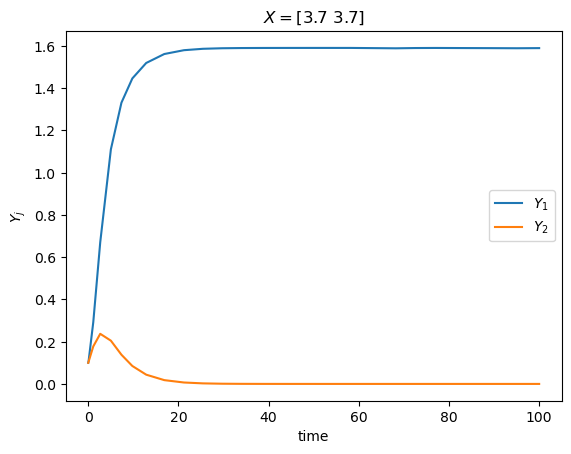

In [2]:
def func_t(t,y,R,W0,W,x):
    f = R*W0 + R*W@x
    Dy = f*y/(1+np.sum(y)) - y
    return Dy#np.array([(0.35 * x[0] * y[0] + 0.35 * x[1] * y[0])/(1+np.sum(y)) - y[0],  2 * y[1]/(1+np.sum(y)) - y[1]])

y0 = np.array([0.1,0.1])
R = 1.
W0 = np.array([0,2])
W = np.array([[0.35, 0.35],
             [0.,0.]])
X = np.array([3.7,3.7])
sol = scipy.integrate.solve_ivp(func_t, [0, 100], y0, args=(R,W0,W,X,), dense_output=True)

plt.plot(sol.t,sol.y[0,:],label=r'$Y_1$')
plt.plot(sol.t,sol.y[1,:],label=r'$Y_2$')
plt.xlabel(r'time')
plt.ylabel(r'$Y_j$')
plt.title(r'$X = $'+str(X))
plt.legend()

In [3]:
## we solve this system by integrating the dynamical equations
x1,x2 = np.arange(0.1,4.1,0.1), np.arange(0.1,4.1,0.1)
X1, X2 = np.meshgrid(x1,x2)
Y1, Y2 = np.zeros_like(X1), np.zeros_like(X2)
y0 = np.array([0.1,0.1])
for i_2,X_2 in enumerate(x2):
    for i_1,X_1 in enumerate(x1):
        X = np.array([X_1,X_2])
        sol = scipy.integrate.solve_ivp(func_t, [0, 60], y0,
                                        args=(R,W0,W,X,), dense_output=True)
        Y1[i_2,i_1] = sol.y[0,-1]
        Y2[i_2,i_1] = sol.y[1,-1]        

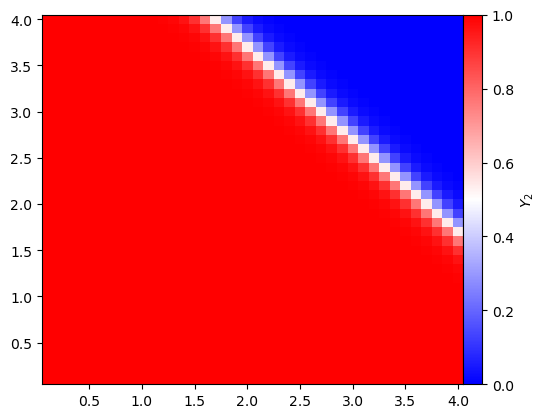

In [4]:
pcm = plt.pcolormesh(X1,X2,Y2,vmin=0,vmax=1,cmap='bwr')
plt.colorbar(pcm, label=r'$Y_2$', pad=0)

In [5]:
## we now solve this system using the steady state criterion 
def func_min(x,R,W0,W):
    f = R*W0 + R*(W@x)
    Y_ss_idx = np.argmin(1/f)
    return np.array([ Y_ss_idx, f[Y_ss_idx] - 1])

X = np.array([3.7,3.7])
Y_ss = func_min(X,R,W0,W)
print(Y_ss)

[0.   1.59]


In [6]:
Y_ss1, Y_ss2 = np.zeros_like(X1), np.zeros_like(X2)
Results = [Y_ss1, Y_ss2]
for i_2,X_2 in enumerate(x2):
    for i_1,X_1 in enumerate(x1):
        X = np.array([X_1,X_2])
        Y_ss = func_min(X,R,W0,W)
        
        Results[int(Y_ss[0])][i_2,i_1] = Y_ss[1]

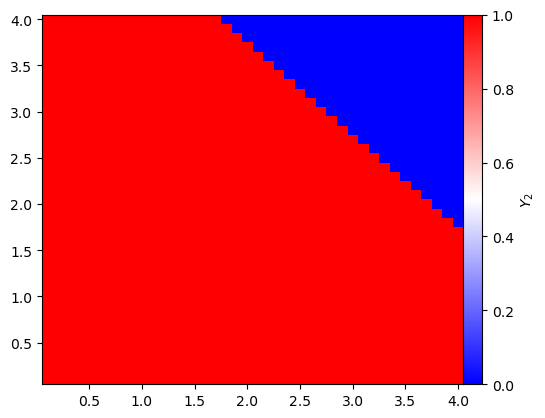

In [7]:
pcm = plt.pcolormesh(X1,X2,Y_ss2,vmin=0,vmax=1,cmap='bwr')
plt.colorbar(pcm, label=r'$Y_2$', pad=0)

In [10]:
## let's test our ICL wta implementation using softmax and softplus 
def func_soft(x,R,W0,W):
    f = R*W0 + R*(W@x)
    weights = scipy.special.softmax(-100/(f + 1e-8))
    arg = f - 1.
    Y_pot = 1/10. * np.log(1. + np.exp(10. * arg))
    return weights*Y_pot

X = np.array([3.7,3.7])
Y_ss = func_soft(X,R,W0,W)
print(Y_ss)

[1.58998203e+00 1.13083625e-05]


In [11]:
x1,x2 = np.arange(0.1,4.1,0.1), np.arange(0.1,4.1,0.1)
X1, X2 = np.meshgrid(x1,x2)
Y_soft1, Y_soft2 = np.zeros_like(X1), np.zeros_like(X2)
for i_2,X_2 in enumerate(x2):
    for i_1,X_1 in enumerate(x1):
        X = np.array([X_1,X_2])
        Y_soft = func_soft(X,R,W0,W)
        Y_soft1[i_2,i_1] = Y_soft[0]
        Y_soft2[i_2,i_1] = Y_soft[1]

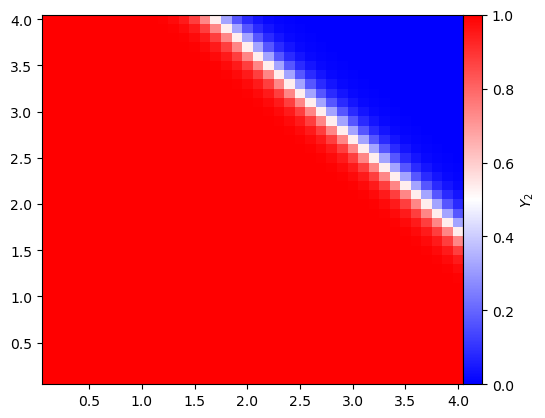

In [12]:
pcm = plt.pcolormesh(X1,X2,Y_soft2,vmin=0,vmax=1,cmap='bwr')
plt.colorbar(pcm, label=r'$Y_2$', pad=0)

3.4947205767477496 2.1495925544197946e-06 2.4999965306281196


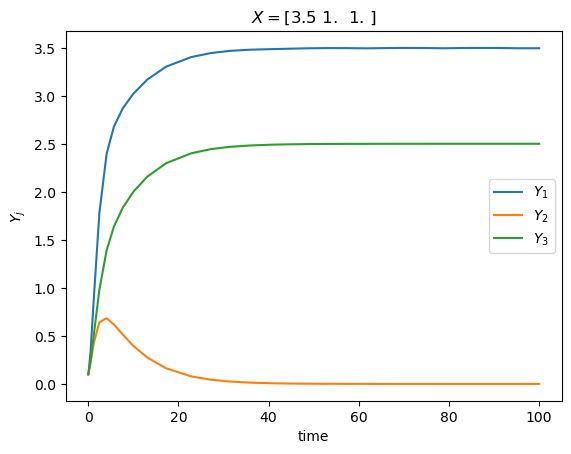

In [11]:
#what about multiple resevoirs... dynamical solution 
def func_ts(t,y,y_idxs,Rs,W0s,Ws,x):
    Dys = np.zeros_like(y)
    for R_i,R in enumerate(Rs):
        f = R*W0s[R_i] + R*Ws[R_i]@x
        Dys += f*y*y_idxs[R_i]/(1+np.sum(y*y_idxs[R_i])) 
    return Dys - y

y0 = np.array([0.1,0.1,0.1])
y_idxs = np.array([ [1,1,0],
                    [0,1,1] ])
Rs = np.array([1.,1.])
W0s = np.array([[0.,1.7,0.],
               [0.,1.7,8.]])

Ws = np.array([ [ [1.0, 1.0, 0.0],
               [0.0, 0.0, 0.0],
               [0.0, 0.0, 0.0] ],
             [ [0.0, 0.0, 0.0],
               [0.0, 0.0, 0.0],
               [-1.0, 0.0, -1.0] ] ])

x_1, x_2 = 3.5, 1.0
X = np.array([x_1,x_2,x_2])
sol = scipy.integrate.solve_ivp(func_ts, [0, 100], y0, args=(y_idxs,Rs,W0s,Ws,X), dense_output=True)
plt.plot(sol.t,sol.y[0,:],label=r'$Y_1$')
plt.plot(sol.t,sol.y[1,:],label=r'$Y_2$')
plt.plot(sol.t,sol.y[2,:],label=r'$Y_3$')
plt.xlabel(r'time')
plt.ylabel(r'$Y_j$')
plt.title(r'$X = $'+str(X))
plt.legend()
print(sol.y[0,-1],sol.y[1,-1],sol.y[2,-1])

In [12]:
## we solve this system by integrating the dynamical equations
x1,x2 = np.arange(0.1,4.1,0.1), np.arange(0.1,4.1,0.1)
X1, X2 = np.meshgrid(x1,x2)
Y1, Y2, Y3 = np.zeros_like(X1), np.zeros_like(X2), np.zeros_like(X2)
y0 = np.array([0.1,0.1,0.1])
for i_2,X_2 in enumerate(x2):
    for i_1,X_1 in enumerate(x1):
        X = np.array([X_1,X_2,X_2])
        sol = scipy.integrate.solve_ivp(func_ts, [0, 100], y0, args=(y_idxs,Rs,W0s,Ws,X), dense_output=True)
        
        Y1[i_2,i_1] = sol.y[0,-1]
        Y2[i_2,i_1] = sol.y[1,-1]
        Y3[i_2,i_1] = sol.y[2,-1]

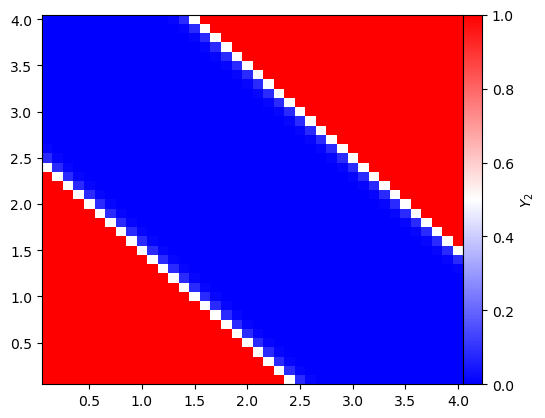

In [13]:
pcm = plt.pcolormesh(X1,X2,Y2,vmin=0,vmax=1,cmap='bwr')
plt.colorbar(pcm, label=r'$Y_2$', pad=0)

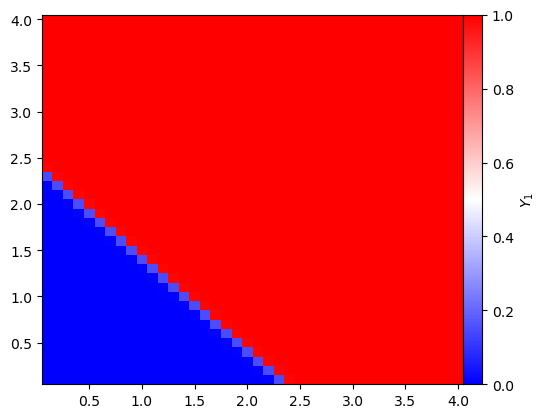

In [14]:
pcm = plt.pcolormesh(X1,X2,Y1,vmin=0,vmax=1,cmap='bwr')
plt.colorbar(pcm, label=r'$Y_1$', pad=0)

In [38]:
## let's test our ICL wta implementation using softmax and softplus 
def func_softs(x,Rs,W0s,Ws):
    Y_s, Y_pots, fs = np.zeros(W0s[0].size), np.zeros(W0s[0].size), np.zeros(W0s[0].size)
    for R_i, R in enumerate(Rs):
        #Ys += func_soft(x,R,,Ws[R_i])
        fs += R*W0s[R_i] + R*(Ws[R_i]@x)
    args = fs - 1.
    Y_pots += 1/10. * np.log(1. + np.exp(10. * args))
    #weights = scipy.special.softmax(-100/(fs + 1e-8))
    Y_s[np.argsort(Y_pots)[-2:]] = Y_pots[np.argsort(Y_pots)[-2:]] 
    return Y_s
    
x_1, x_2 = 3.5, 1.0
X = np.array([x_1,x_2,x_2])
Y_ss = func_softs(X,Rs,W0s,Ws)
print(Y_ss)

[3.5 0.  2.5]


In [39]:
Y_soft1, Y_soft2, Y_soft3 = np.zeros_like(X1), np.zeros_like(X2), np.zeros_like(X2)
for i_2,X_2 in enumerate(x2):
    for i_1,X_1 in enumerate(x1):
        X = np.array([X_1,X_2,X_2])
        Y_softs_all = func_softs(X,Rs,W0s,Ws)
        Y_soft1[i_2,i_1] = Y_softs_all[0]
        Y_soft2[i_2,i_1] = Y_softs_all[1]
        Y_soft3[i_2,i_1] = Y_softs_all[2]

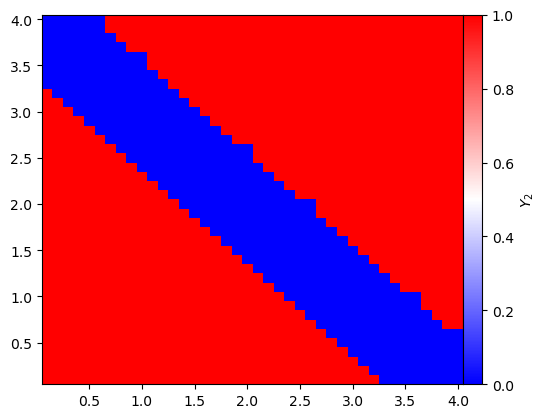

In [40]:
pcm = plt.pcolormesh(X1,X2,Y_soft2,vmin=0,vmax=1,cmap='bwr')
plt.colorbar(pcm, label=r'$Y_2$', pad=0)

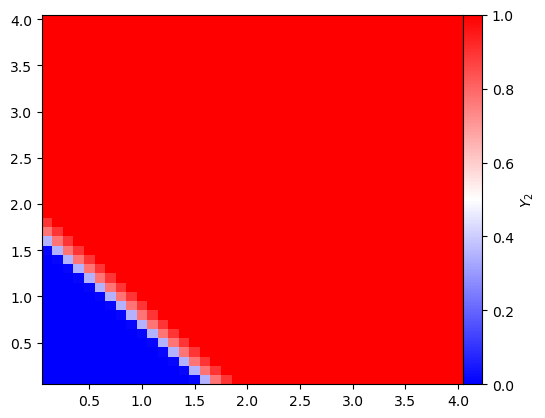

In [19]:
pcm = plt.pcolormesh(X1,X2,Y_soft1,vmin=0,vmax=1,cmap='bwr')
plt.colorbar(pcm, label=r'$Y_2$', pad=0)

In [43]:
np.exp(-3.4930)

0.030409506671477567